In [1]:
import pandas as pd
import altair as alt
import numpy as np
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

# User inputs

In [2]:
start_date = '20221130'
end_date = '20230517'

tidy_dataset_fn = f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_dataset_5min_fn = f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_daily_dataset_output_fn = f"tidy_df_daily_{start_date}_{end_date}_noplanar_fit.parquet"

# Load data

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(
        tidy_dataset_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

try:
    tidy_df_5Min = pd.read_parquet(
        tidy_dataset_5min_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# Examine pot. virtual temperature gradient

In [4]:
np.abs(tidy_df_30Min[tidy_df_30Min.measurement == 'temperature gradient'].value).min()

1.9186053456581349e-07

In [5]:
alt.Chart(
    tidy_df_30Min.query("measurement == 'temperature gradient'").query("height < 5")
).mark_line().encode(
    x = 'time:T',
    y = 'value:Q',
    column='height:O'
) & alt.Chart(
    tidy_df_30Min.query("measurement == 'temperature gradient'").query("height < 5")
).mark_bar().encode(
    alt.X('value:Q').bin(step=0.1),
    alt.Y("count():Q"),    
    alt.Column('height:O')
)

alt.VConcatChart(...)

In [6]:
src = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'")
neutral_times = src[src['value'].abs() < 0.01].time

In [8]:
alt.Chart(
    tidy_df_30Min[
        tidy_df_30Min.time.isin(neutral_times.sample(16))
    ].query("measurement == 'wind speed'").query("tower == 'c'")
).mark_line().encode(
    alt.X("value:Q").title("Wind speed (m/s)").sort('-y'),
    alt.Y("height:Q").title("Height (m)"),
    alt.Facet("time:O", columns=8)
).properties(width = 125, height = 125)

alt.Chart(...)

In [9]:
src = tidy_df_30Min[
    tidy_df_30Min.time.isin(neutral_times)
].query("tower == 'c'")
src = src[src.measurement.isin([
    'wind speed',
    'shear velocity'
])]
src = src[~src.variable.str.contains("predicted")]
src = src.pivot_table(index=['time'], values='value', columns='variable')
src.head()

variable,spd_10m_c,spd_15m_c,spd_20m_c,spd_2m_c,spd_3m_c,spd_5m_c,u*_10m_c,u*_15m_c,u*_20m_c,u*_2m_c,u*_3m_c,u*_5m_c
time,,,,,,,,,,,,
2022-11-30 13:00:00,0.800948,0.800862,0.784039,0.765804,0.782629,0.789314,0.095672,0.083350,0.094714,0.071688,0.071907,0.090291
2022-12-15 09:00:00,0.850726,0.785895,0.733864,0.826955,0.838186,0.878394,0.084738,0.094191,0.101873,0.080567,0.075521,0.077648
2022-12-15 09:30:00,1.021760,0.939092,0.978009,0.902828,0.926294,0.966122,0.096680,0.099007,0.106793,0.089038,0.084346,0.072335
2022-12-17 13:00:00,1.625854,1.626013,1.645000,1.440014,1.485815,1.524601,0.114225,0.117330,0.136969,0.091406,0.096536,0.115326
2022-12-19 12:00:00,1.588373,1.662750,1.754808,1.436062,1.462702,1.514731,0.133751,0.151732,0.191569,0.097158,0.104393,0.103646


# Solve for $z_0$ assuming $d = 0$

https://www.eol.ucar.edu/content/calculation-roughness-length-and-displacement-height

In [26]:
von_karman = 0.4

In [27]:
src['z0_2m_c'] = 2/np.exp(src['spd_2m_c']*von_karman/src['u*_2m_c'])
src['z0_3m_c'] = 3/np.exp(src['spd_3m_c']*von_karman/src['u*_3m_c'])
src['z0_5m_c'] = 5/np.exp(src['spd_5m_c']*von_karman/src['u*_5m_c'])
src['z0_10m_c'] = 10/np.exp(src['spd_10m_c']*von_karman/src['u*_10m_c'])
src['z0_15m_c'] = 15/np.exp(src['spd_15m_c']*von_karman/src['u*_15m_c'])
src['z0_20m_c'] = 20/np.exp(src['spd_20m_c']*von_karman/src['u*_20m_c'])

In [28]:
src[['z0_2m_c', 'z0_3m_c', 'z0_5m_c', 'z0_10m_c', 'z0_15m_c', 'z0_20m_c']].mean()

variable
z0_2m_c     0.041842
z0_3m_c     0.048230
z0_5m_c     0.059109
z0_10m_c    0.238737
z0_15m_c    0.374024
z0_20m_c    0.647528
dtype: float64

# Solve for $z_0$ by fitting a line

In [29]:
y = src.iloc[0][
    ['spd_2m_c', 'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_15m_c', 'spd_20m_c']
].values
x = np.array([np.log(2), np.log(3), np.log(5), np.log(10), np.log(15), np.log(20)])

In [30]:
import matplotlib.pyplot as plt

In [31]:
import scipy

In [32]:
regress_result = scipy.stats.linregress(x[:-1],y[:-1])
regress_result

LinregressResult(slope=0.016738033844553236, intercept=0.7597517849062632, rvalue=0.9505022777914653, pvalue=0.013120810497748993, stderr=0.0031590499308212336, intercept_stderr=0.005810097695392996)

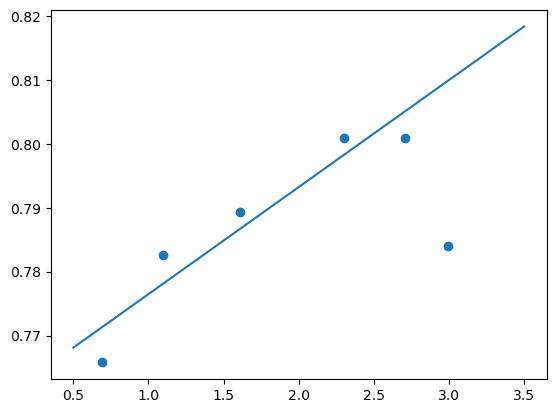

In [33]:
xs = np.linspace(0.5, 3.5, 10)
ys = regress_result.slope*xs + regress_result.intercept

plt.scatter(x,y)
plt.plot(xs,ys)

In [34]:
u_star = regress_result.slope*von_karman
u_star

0.006695213537821295

In [35]:
z0 = np.exp(-regress_result.intercept * von_karman / u_star)
z0

1.936649304829132e-20